<a href="https://colab.research.google.com/github/hellocybernetics/Tensorflow-Probability-Tutorials/blob/master/edward2_logistic_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install tensorflow-probability

    100% |████████████████████████████████| 686kB 19.0MB/s 


In [0]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [0]:
tfd = tfp.distributions
tfe = tf.contrib.eager
ed = tfp.edward2

In [0]:
tf.enable_eager_execution()

In [0]:

normal_rv = ed.Normal(loc=0., scale=1.)
## <ed.RandomVariable 'Normal/' shape=() dtype=float32>
normal_rv.distribution.log_prob(1.231)
## <tf.Tensor 'Normal/log_prob/sub:0' shape=() dtype=float32>

dirichlet_rv = ed.Dirichlet(concentration=tf.ones([2, 10]))
## <ed.RandomVariable 'Dirichlet/' shape=(2, 10) dtype=float32>

In [8]:
print(normal_rv.__doc__)

Class for random variables.

  `RandomVariable` encapsulates properties of a random variable, namely, its
  distribution, sample shape, and (optionally overridden) value. Its `value`
  property is a `tf.Tensor`, which embeds the `RandomVariable` object into the
  TensorFlow graph. `RandomVariable` also features operator overloading and
  registration to TensorFlow sessions, enabling idiomatic usage as if one were
  operating on `tf.Tensor`s.

  The random variable's shape is given by

  `sample_shape + distribution.batch_shape + distribution.event_shape`,

  where `sample_shape` is an optional argument describing the shape of
  independent, identical draws from the distribution (default is `()`, meaning
  a single draw); `distribution.batch_shape` describes the shape of
  independent-but-not-identical draws (determined by the shape of the
  distribution's parameters); and `distribution.event_shape` describes the
  shape of dependent dimensions (e.g., `Normal` has scalar `event_shape`;


In [0]:
rv_normal = ed.RandomVariable(tfd.Normal(loc=tf.zeros([]), scale=tf.ones([])))
rv_normal_ed = ed.Normal(loc=tf.zeros([]), scale=tf.ones([]))

In [9]:
print(rv_normal)
print(rv_normal_ed)

RandomVariable("-0.8575304", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
RandomVariable("1.0416814", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)


In [10]:
print(ed.Normal(loc=0, scale=1))
print(ed.RandomVariable(tfd.Normal(loc=0, scale=1)))

RandomVariable("0.47262925", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
RandomVariable("-0.91771996", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)


In [0]:
def logistic_regression(X):
    # w.shape == (X.shape[1])
    w = ed.Normal(loc=tf.zeros(X.shape[1]), scale=1., name="w")
    # b.shape == (1,)
    b = ed.Normal(loc=0., scale=1., name="b")

    # y.shape == (X.shape[0])
    y = ed.Bernoulli(
        logits=tf.tensordot(X, w, [[1], [0]]) + b,
        name="y")
    return y

num_features = 10
X = tf.random_normal([100, num_features])
y = logistic_regression(X)

In [21]:
y

<tf.Tensor: id=421, shape=(100,), dtype=int32, numpy=
array([0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0], dtype=int32)>

In [0]:
def logistic_regression_posterior(num_features):
    """Posterior of Bayesian logistic regression p(w, b | {x, y})."""
    posterior_w = ed.MultivariateNormalTriL(
        loc=tf.get_variable("w_loc", [num_features]),
        scale_tril=tfp.trainable_distributions.tril_with_diag_softplus_and_shift(
          tf.get_variable("w_scale", [num_features*(num_features+1) / 2])),
        name="w_posterior")
    posterior_b = ed.Normal(
        loc=tf.get_variable("b_loc", []),
        scale=tfp.trainable_distributions.softplus_and_shift(
          tf.get_variable("b_scale", [])),
        name="b_posterior")
    return posterior_w, posterior_b

posterior_w, posterior_b = logistic_regression_posterior(num_features)


In [7]:
print(posterior_w)
print(posterior_b)

RandomVariable("
[-1.5937399   0.0209088  -0.96262723  1.1284826  -0.17871648 -0.64187694
 -0.40995038  1.7975961   0.5990304   0.6936111 ]", shape=(10,), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)
RandomVariable("-0.9071104", shape=(), dtype=float32, device=/job:localhost/replica:0/task:0/device:GPU:0)


In [0]:
def set_prior_to_posterior_mean(f, *args, **kwargs):
    """Forms posterior predictions, setting each prior to its posterior mean."""
    name = kwargs.get("name")
    if name == "w":
        return posterior_w.distribution.mean()
    elif name == "b":
        return posterior_b.distribution.mean()
    return f(*args, **kwargs)

with ed.interception(set_prior_to_posterior_mean):
    predictions = logistic_regression(X)


def training_accuracy(predictions, y):
    return (
        tf.reduce_sum(tf.cast(tf.equal(predictions, y), tf.float32)) /
        tf.cast(tf.shape(y), tf.float32))

In [9]:
print(predictions)
print(training_accuracy(predictions, y))

RandomVariable("
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1
 1 0 0 0 0 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 0 0
 1 0 1 0 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 0 0 0 0 1]", shape=(100,), dtype=int32, device=/job:localhost/replica:0/task:0/device:GPU:0)
tf.Tensor([0.51], shape=(1,), dtype=float32)


In [0]:
X = tf.random_normal([100, 4])
y = tf.random_uniform([100], minval=0, maxval=2, dtype=tf.int32)

# Pass target log-probability function to MCMC transition kernel.
log_joint = ed.make_log_joint_fn(logistic_regression)

def target_log_prob_fn(w, b):
    """Target log-probability as a function of states."""
    return log_joint(X,
                   w=w,
                   b=b,
                   y=y)

hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=target_log_prob_fn,
    step_size=0.1,
    num_leapfrog_steps=5)
states, kernel_results = tfp.mcmc.sample_chain(
    num_results=1000,
    current_state=[tf.random_normal([4]), tf.random_normal([])],
    kernel=hmc_kernel,
    num_burnin_steps=500)

In [37]:
print(states[0].shape)
print(states[1].shape)

(1000, 4)
(1000,)


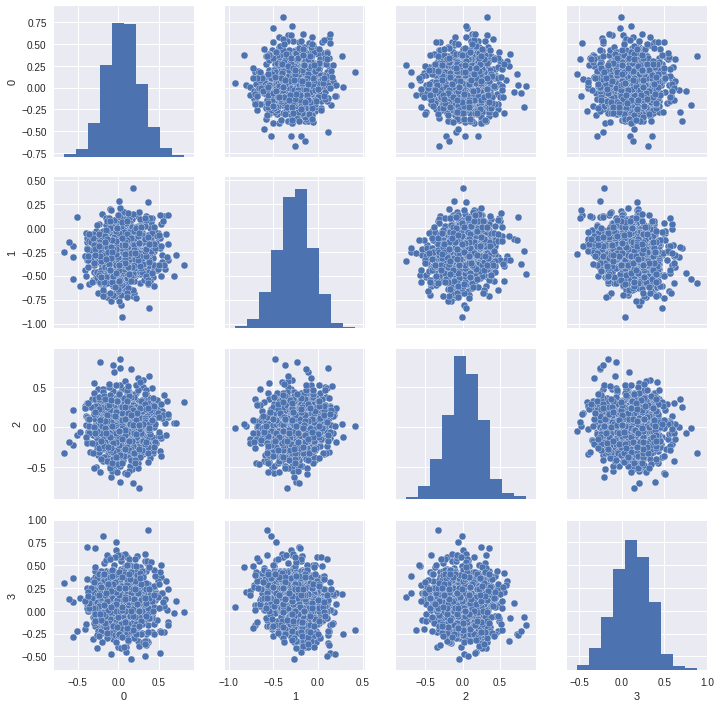

In [38]:
sns.pairplot(pd.DataFrame(states[0].numpy()))

mean:  0.18845236
std:  0.20227498


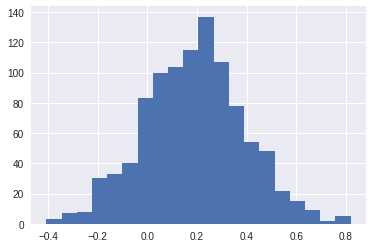

In [45]:
plt.hist(states[1], bins=20)
print('mean: ', states[1].numpy().mean())
print('std: ', states[1].numpy().std())

2